In [138]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
from adjustText import adjust_text

In [139]:
def parse_log(file_path):
    pattern = re.compile(r'(\d+\.\d+\.\d+\.\d+)\|-\|\[(.*?)\]\|.*?\|\"(.*?)\"\|(\d+)\|(\d+)\|.*?\|.*?\|.*?\|(\d+\.\d+)\|-')
    log_data = []
    with open(file_path, 'r') as file:
        for line in file:
            match = pattern.match(line)
            if match:
                #Extract relevant metrics using regex groups 
                ip_address = match.group(1)
                timestamp = match.group(2)
                request = match.group(3)
                status = match.group(4)
                response_size = match.group(5)
                response_time = match.group(6)
                
                # Store the extracted data in the log_data list
                log_data.append([ip_address, timestamp, request, status, response_size, response_time])
    
    columns = ['IP Address', 'Timestamp', 'Request URL', 'Status', 'Response Size', 'Response Time']

    df = pd.DataFrame(log_data, columns=columns)
    
    with pd.option_context('mode.use_inf_as_na', True):
        df['Status'] = pd.to_numeric(df['Status'])
        df['Response Size'] = pd.to_numeric(df['Response Size'])
        df['Response Time'] = pd.to_numeric(df['Response Time'])
        
        df.dropna(subset=['Response Size'], inplace=True)
        df['Response Time'].fillna(0, inplace=True)
        
        response_time_mean = df['Response Time'].mean()
        response_time_std = df['Response Time'].std()
        df = df[(df['Response Time'] >= (response_time_mean - 3 * response_time_std)) & 
                (df['Response Time'] <= (response_time_mean + 3 * response_time_std))]
        
        df = df[(df['Status'] >= 200) & (df['Status'] <= 599)]
    

    df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d/%b/%Y:%H:%M:%S %z')
     
    display(df)
    return df 


log_file = './nginx.log' 

metric_df = parse_log(log_file)

                

/var/folders/2d/885m9y510z34twwvmvvfdkk00000gn/T/ipykernel_18962/1897210180.py:23: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


,IP Address,Timestamp,Request URL,Status,Response Size,Response Time
0,138.201.82.215,2024-06-30 16:52:14+00:00,GET /api/.env.staging HTTP/1.1,301,175,0.000
1,138.201.82.215,2024-06-30 16:52:14+00:00,GET /api/.env.production HTTP/1.1,301,175,0.000
2,138.201.82.215,2024-06-30 16:52:15+00:00,GET /apis/.env HTTP/1.1,301,175,0.000
3,138.201.82.215,2024-06-30 16:52:15+00:00,GET /apis/.env.local HTTP/1.1,301,175,0.000
4,138.201.82.215,2024-06-30 16:52:15+00:00,GET /apis/.env.staging HTTP/1.1,301,175,0.000
...,...,...,...,...,...,...
4310,51.159.214.49,2024-07-04 15:49:40+00:00,GET /favicon.ico HTTP/1.1,200,4286,0.000
4311,51.159.214.49,2024-07-04 15:49:46+00:00,GET /polyfills.js HTTP/1.1,200,141681,0.171
4312,51.159.214.49,2024-07-04 15:49:47+00:00,GET /main.js HTTP/1.1,200,33609,0.000
4313,49.207.190.110,2024-07-04 16:05:19+00:00,GET /assets/api/dashboard/default-board.json H...,304,0,0.000


In [140]:
def agg_df(df, interval='T'):
    df_copy = df.copy()
    df_copy.set_index('Timestamp', inplace=True)

    aggregated_df = df_copy.resample(interval).agg({
        'IP Address': 'count',      # Number of requests
        'Response Size': 'sum',     # Total response size
        'Response Time': 'mean',    # Average response time
        'Status': 'count'           # Number of responses
    }).rename(columns={
        'IP Address': 'Request Count',
        'Status': 'Response Count'
    })

    return aggregated_df


aggregated_df = agg_df(metric_df, interval='T')

display(aggregated_df)



,Request Count,Response Size,Response Time,Response Count
Timestamp,,,,
2024-06-30 16:52:00+00:00,167,29225,0.000,167
2024-06-30 16:53:00+00:00,126,22050,0.000,126
2024-06-30 16:54:00+00:00,0,0,NaN,0
2024-06-30 16:55:00+00:00,2,4449,0.473,2
2024-06-30 16:56:00+00:00,0,0,NaN,0
...,...,...,...,...
2024-07-04 16:01:00+00:00,0,0,NaN,0
2024-07-04 16:02:00+00:00,0,0,NaN,0
2024-07-04 16:03:00+00:00,0,0,NaN,0


In [141]:
def feature_engineering(d_f):
    if 'Timestamp' not in d_f.columns:
        raise KeyError("The 'Timestamp' column is missing from the DataFrame.")

    df = d_f.copy()
    df.set_index('Timestamp', inplace=True)
    
    # Group by IP address and resample by minute
    grouped_ip = df.groupby('IP Address').resample('T')
    
    features_ip = pd.DataFrame()
    
    features_ip['request_count_per_min'] = grouped_ip['Request URL'].count()
    features_ip['unique_url_count_per_min'] = grouped_ip['Request URL'].nunique()
    features_ip['burstiness'] = features_ip['request_count_per_min'].diff().fillna(0)
    
    # Filter out IPs with low request counts
    min_request_count = 1
    features_ip = features_ip[features_ip['request_count_per_min'] >= min_request_count]
    
    features_ip.fillna(0, inplace=True)
    features_ip.reset_index(inplace=True)
    
    # Group by timestamp for overall request counts
    grouped_overall = df.resample('T')
    
    features_overall = pd.DataFrame()
    features_overall['total_request_count_per_minute'] = grouped_overall['Request URL'].count()
    features_overall['total_response_time_per_minute'] = grouped_overall['Response Time'].sum()
    features_overall['total_response_size_per_minute'] = grouped_overall['Response Size'].sum()
    
    features_overall.fillna(0, inplace=True)
    features_overall.reset_index(inplace=True)
    
    # Group by status code and resample by minute
    grouped_status = df.groupby([pd.Grouper(freq='T'), 'Status']).size().unstack(fill_value=0)
    
    features_status = pd.DataFrame(grouped_status)
    
    features_status.fillna(0, inplace=True)
    
    return features_ip, features_overall, features_status

features_ip, features_overall, features_status= feature_engineering(metric_df)

print("Feature-Engineered DataFrame for IPs:")
display(features_ip)

print("Feature-Engineered DataFrame for Overall Request Counts:")
display(features_overall)

print("Feature-Engineered DataFrame for Status Codes:")
display(features_status)

Feature-Engineered DataFrame for IPs:


,IP Address,Timestamp,request_count_per_min,unique_url_count_per_min,burstiness
0,1.14.13.19,2024-07-03 06:51:00+00:00,1,1,0.0
1,1.14.7.100,2024-06-30 17:18:00+00:00,1,1,0.0
2,1.14.7.100,2024-06-30 22:28:00+00:00,1,1,1.0
3,1.14.7.100,2024-07-01 04:31:00+00:00,1,1,1.0
4,1.14.7.100,2024-07-01 07:44:00+00:00,1,1,1.0
...,...,...,...,...,...
712,94.229.237.204,2024-07-04 15:01:00+00:00,1,1,-1.0
713,94.232.44.144,2024-07-03 03:17:00+00:00,3,1,2.0
714,94.43.59.154,2024-07-04 06:47:00+00:00,1,1,-2.0
715,94.99.47.108,2024-07-02 12:19:00+00:00,1,1,0.0


Feature-Engineered DataFrame for Overall Request Counts:


,Timestamp,total_request_count_per_minute,total_response_time_per_minute,total_response_size_per_minute
0,2024-06-30 16:52:00+00:00,167,0.000,29225
1,2024-06-30 16:53:00+00:00,126,0.000,22050
2,2024-06-30 16:54:00+00:00,0,0.000,0
3,2024-06-30 16:55:00+00:00,2,0.946,4449
4,2024-06-30 16:56:00+00:00,0,0.000,0
...,...,...,...,...
5709,2024-07-04 16:01:00+00:00,0,0.000,0
5710,2024-07-04 16:02:00+00:00,0,0.000,0
5711,2024-07-04 16:03:00+00:00,0,0.000,0
5712,2024-07-04 16:04:00+00:00,0,0.000,0


Feature-Engineered DataFrame for Status Codes:


Status,200,206,301,304,400,401,404,500
Timestamp,,,,,,,,
2024-06-30 16:52:00+00:00,0,0,167,0,0,0,0,0
2024-06-30 16:53:00+00:00,0,0,126,0,0,0,0,0
2024-06-30 16:55:00+00:00,1,0,0,0,1,0,0,0
2024-06-30 17:06:00+00:00,0,0,0,0,2,0,0,1
2024-06-30 17:18:00+00:00,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
2024-07-04 15:31:00+00:00,0,0,2,0,0,0,0,0
2024-07-04 15:38:00+00:00,2,0,0,0,0,0,0,0
2024-07-04 15:46:00+00:00,0,0,0,0,1,0,0,0


In [142]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

def train_and_evaluate(features, feature_columns):
    # Ensure feature columns exist
    for col in feature_columns:
        if col not in features.columns:
            raise KeyError(f"'{col}' not in the DataFrame columns")
    
    X = features[feature_columns].fillna(0)
    
    # Split data into training, development, and testing sets
    X_train, X_temp = train_test_split(X, test_size=0.3, random_state=42)
    X_dev, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)
    
    # Train Isolation Forest model on the training set
    model = IsolationForest(contamination=0.01, random_state=42)
    model.fit(X_train)
    
    # Predict anomalies on the development and testing sets
    features_dev = X_dev.copy()
    features_dev['anomaly_score'] = model.decision_function(X_dev)
    features_dev['anomaly'] = model.predict(X_dev)

    features_test = X_test.copy()
    features_test['anomaly_score'] = model.decision_function(X_test)
    features_test['anomaly'] = model.predict(X_test)

    return model, features_dev, features_test
    

In [143]:
# Train and evaluate model for IP-related features
ip_feature_columns = ['request_count_per_min', 'unique_url_count_per_min', 'burstiness']
model_ip, dev_ip, test_ip = train_and_evaluate(features_ip, ip_feature_columns)

dev_ip['Timestamp'] = features_ip.loc[dev_ip.index, 'Timestamp']
dev_ip['IP Address'] = features_ip.loc[dev_ip.index, 'IP Address']

test_ip['Timestamp'] = features_ip.loc[test_ip.index, 'Timestamp']
test_ip['IP Address'] = features_ip.loc[test_ip.index, 'IP Address']

print("Development Set Anomaly Scores and Labels for IP Features:")
display(dev_ip)

print("Testing Set Anomaly Scores and Labels for 3IP Features:")
display(test_ip)

Development Set Anomaly Scores and Labels for IP Features:


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


,request_count_per_min,unique_url_count_per_min,burstiness,anomaly_score,anomaly,Timestamp,IP Address
65,2,2,-57.0,0.095963,1,2024-07-03 06:42:00+00:00,110.226.38.71
72,1,1,0.0,0.376802,1,2024-07-02 17:01:00+00:00,115.187.39.70
174,126,126,-41.0,-0.123848,-1,2024-06-30 16:53:00+00:00,138.201.82.215
89,13,13,13.0,0.120557,1,2024-07-04 08:52:00+00:00,122.171.18.70
24,1,1,-1.0,0.363535,1,2024-07-02 05:33:00+00:00,103.206.16.110
...,...,...,...,...,...,...,...
490,1,1,0.0,0.376802,1,2024-06-30 23:50:00+00:00,45.79.181.179
208,1,1,-3.0,0.337576,1,2024-07-03 15:19:00+00:00,162.216.149.11
324,2,2,2.0,0.344833,1,2024-07-01 17:44:00+00:00,185.254.196.173
649,1,1,1.0,0.367830,1,2024-07-01 22:53:00+00:00,66.240.205.34


Testing Set Anomaly Scores and Labels for 3IP Features:


,request_count_per_min,unique_url_count_per_min,burstiness,anomaly_score,anomaly,Timestamp,IP Address
643,1,1,0.0,0.376802,1,2024-07-04 04:48:00+00:00,65.49.1.110
223,1,1,-1.0,0.363535,1,2024-07-02 17:56:00+00:00,167.71.207.184
429,1,1,0.0,0.376802,1,2024-07-03 16:19:00+00:00,34.244.184.187
591,1,1,1.0,0.367830,1,2024-07-04 11:22:00+00:00,49.43.240.16
422,1,1,0.0,0.376802,1,2024-07-02 21:35:00+00:00,27.98.228.200
...,...,...,...,...,...,...,...
530,12,12,12.0,0.126237,1,2024-07-04 12:02:00+00:00,49.205.145.222
469,1,1,0.0,0.376802,1,2024-06-30 20:05:00+00:00,45.156.128.49
97,5,5,5.0,0.236572,1,2024-07-04 10:32:00+00:00,122.171.18.70
536,58,58,58.0,0.114893,1,2024-07-04 05:46:00+00:00,49.207.190.110


In [144]:
# Train and evaluate model for overall request count features
overall_feature_columns = ['total_request_count_per_minute', 'total_response_time_per_minute', 'total_response_size_per_minute']
model_overall, dev_overall, test_overall = train_and_evaluate(features_overall, overall_feature_columns)

print("Development Set Anomaly Scores and Labels for Overall Request Count Features:")
display(dev_overall)

print("Testing Set Anomaly Scores and Labels for Overall Request Count Features:")
display(test_overall)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Development Set Anomaly Scores and Labels for Overall Request Count Features:


,total_request_count_per_minute,total_response_time_per_minute,total_response_size_per_minute,anomaly_score,anomaly
3858,0,0.0,0,0.475259,1
5264,1,0.0,585,0.351241,1
2937,0,0.0,0,0.475259,1
1876,0,0.0,0,0.475259,1
5707,0,0.0,0,0.475259,1
...,...,...,...,...,...
2921,0,0.0,0,0.475259,1
5123,0,0.0,0,0.475259,1
4428,0,0.0,0,0.475259,1
4526,0,0.0,0,0.475259,1


Testing Set Anomaly Scores and Labels for Overall Request Count Features:


,total_request_count_per_minute,total_response_time_per_minute,total_response_size_per_minute,anomaly_score,anomaly
3306,0,0.00,0,0.475259,1
4734,0,0.00,0,0.475259,1
3121,0,0.00,0,0.475259,1
257,0,0.00,0,0.475259,1
4868,1,0.00,175,0.389558,1
...,...,...,...,...,...
4700,0,0.00,0,0.475259,1
453,0,0.00,0,0.475259,1
3429,0,0.00,0,0.475259,1
5271,0,0.00,0,0.475259,1


In [145]:
# Train and evaluate model for status code features
status_feature_columns = features_status.columns
print(status_feature_columns)
model_status, dev_status, test_status = train_and_evaluate(features_status, status_feature_columns)

print("Development Set Anomaly Scores and Labels for Status Code Features:")
display(dev_status)

print("Testing Set Anomaly Scores and Labels for Status Code Features:")
display(test_status)

Index([200, 206, 301, 304, 400, 401, 404, 500], dtype='int64', name='Status')
Development Set Anomaly Scores and Labels for Status Code Features:


Status,200,206,301,304,400,401,404,500,anomaly_score,anomaly
Timestamp,,,,,,,,,,
2024-07-03 02:48:00+00:00,0,0,0,0,6,0,0,0,0.087663,1
2024-07-01 05:50:00+00:00,0,0,0,0,1,0,0,0,0.300782,1
2024-07-04 07:10:00+00:00,3,0,0,1,0,0,0,0,0.286111,1
2024-07-02 00:24:00+00:00,0,0,2,0,0,0,0,0,0.313291,1
2024-07-02 10:24:00+00:00,0,0,0,0,1,0,0,0,0.300782,1
...,...,...,...,...,...,...,...,...,...,...
2024-07-01 08:49:00+00:00,53,0,0,0,0,0,0,0,0.182682,1
2024-07-01 14:28:00+00:00,0,0,0,0,2,0,1,0,0.150640,1
2024-06-30 23:54:00+00:00,0,0,2,0,0,0,0,0,0.313291,1


Testing Set Anomaly Scores and Labels for Status Code Features:


Status,200,206,301,304,400,401,404,500,anomaly_score,anomaly
Timestamp,,,,,,,,,,
2024-06-30 16:55:00+00:00,1,0,0,0,1,0,0,0,0.286979,1
2024-07-02 21:45:00+00:00,0,0,1,0,0,0,0,0,0.316757,1
2024-07-04 10:29:00+00:00,94,0,0,45,0,0,1,0,-0.052511,-1
2024-07-04 05:48:00+00:00,0,0,0,1,0,0,0,0,0.301264,1
2024-07-02 08:06:00+00:00,0,0,1,0,0,0,0,0,0.316757,1
...,...,...,...,...,...,...,...,...,...,...
2024-07-04 10:58:00+00:00,63,0,0,0,0,0,0,0,0.145879,1
2024-07-02 12:59:00+00:00,0,0,0,0,0,0,1,0,0.201685,1
2024-07-03 01:09:00+00:00,0,0,1,0,0,0,0,0,0.316757,1


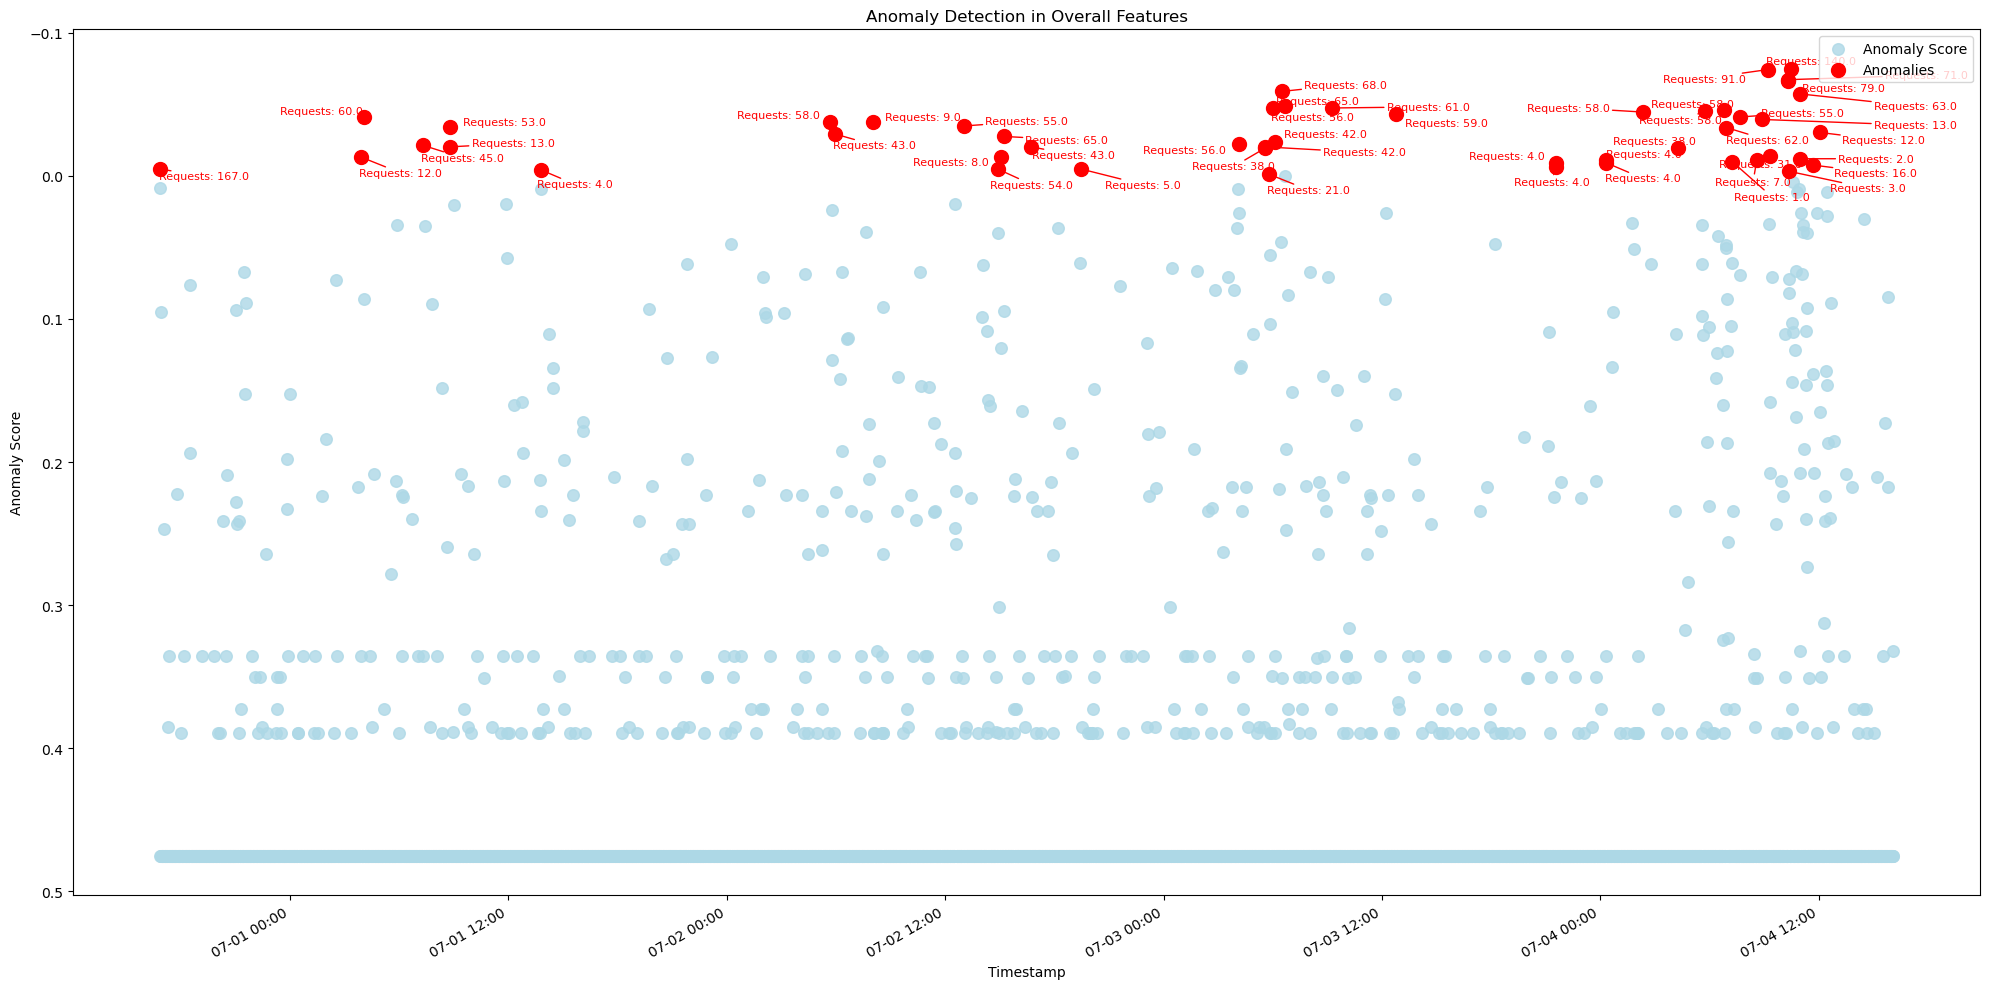

In [146]:
def plot_anomalies_overall(features_overall, model):
    # Ensure Timestamp is in datetime format and set as index
    features_overall['Timestamp'] = pd.to_datetime(features_overall['Timestamp'])
    features_overall.set_index('Timestamp', inplace=True)
    
    # Predict anomalies
    overall_feature_columns = ['total_request_count_per_minute', 'total_response_time_per_minute', 'total_response_size_per_minute']
    X_overall = features_overall[overall_feature_columns].fillna(0)

    features_overall['anomaly_score'] = model.decision_function(X_overall)
    features_overall['anomaly'] = model.predict(X_overall)
    plt.figure(figsize=(20, 10))
    
    # Scatter plot for anomaly score over time
    plt.scatter(features_overall.index, features_overall['anomaly_score'], label='Anomaly Score', color='lightblue', alpha=0.8, s=70)
    
    # Highlight anomalies with red markers
    anomalies = features_overall[features_overall['anomaly'] == -1]
    plt.scatter(anomalies.index, anomalies['anomaly_score'], color='red', label='Anomalies', s=100, zorder=3)
    
    texts = []
    for i, row in anomalies.iterrows():
        annotation = f"Requests: {row['total_request_count_per_minute']}"
        texts.append(plt.text(row.name, row['anomaly_score'], annotation, ha='center', color='red', fontsize=8))
    
    adjust_text(texts, arrowprops=dict(arrowstyle="->", color='red'))
    
    # Invert the y-axis to have positive at the top and negative at the bottom
    plt.gca().invert_yaxis()

    plt.title('Anomaly Detection in Overall Features')
    plt.xlabel('Timestamp')
    plt.ylabel('Anomaly Score')
    plt.legend(loc='upper right')

    # Date formatting
    date_form = DateFormatter("%m-%d %H:%M")
    plt.gca().xaxis.set_major_formatter(date_form)
    plt.gcf().autofmt_xdate()

    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.1)
    
    plt.tight_layout()
    plt.show()


plot_anomalies_overall(features_overall, model_overall)

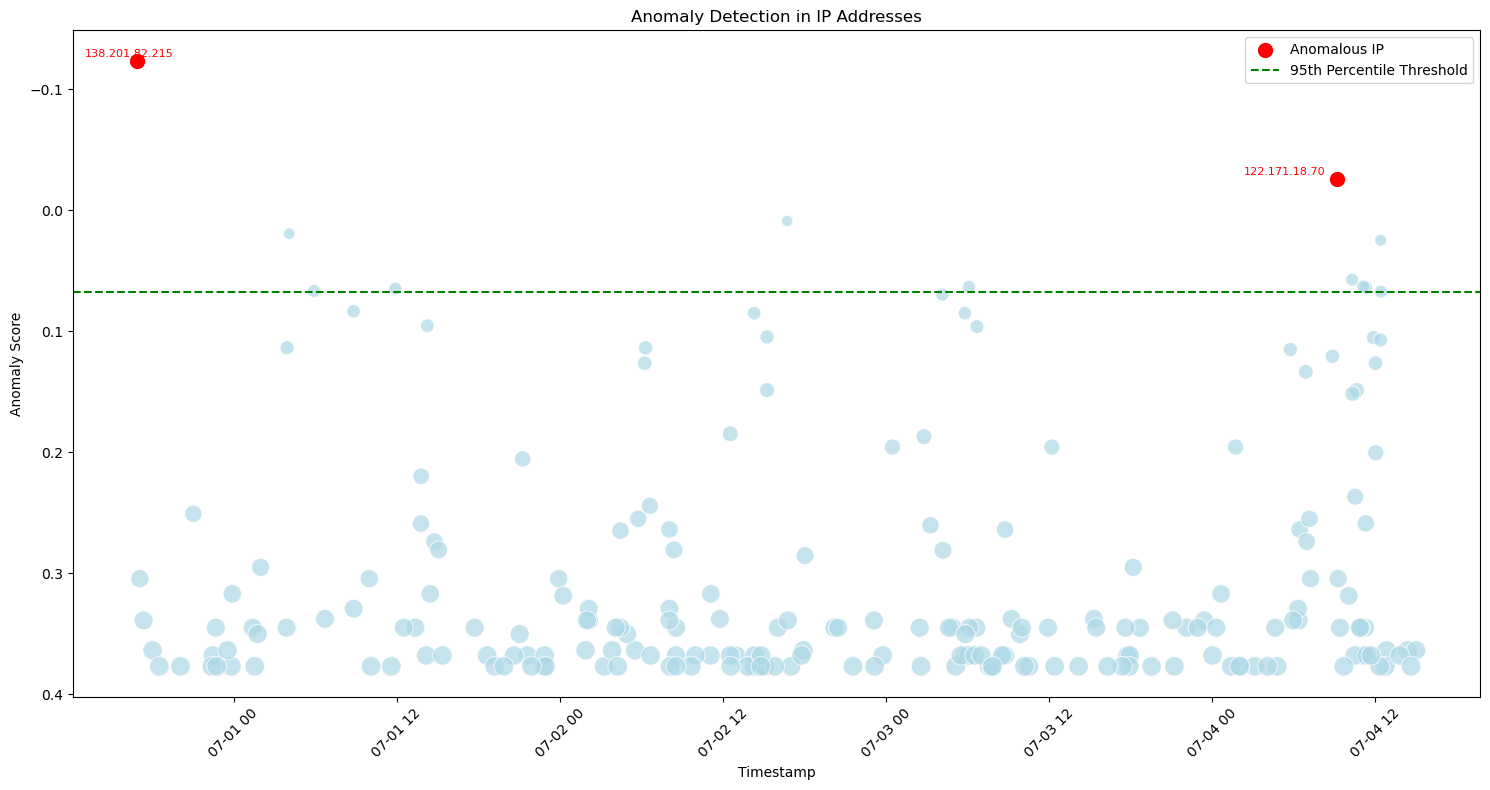

In [148]:
def plot_anomalies_ip(features, timestamp_col='Timestamp', anomaly_col='anomaly_score', ip_col='IP Address'):
    if timestamp_col not in features.columns or anomaly_col not in features.columns or ip_col not in features.columns:
        raise KeyError("One or more required columns are missing from the DataFrame.")
    
    plt.figure(figsize=(15, 8))

    # Create a scatter plot
    scatter = sns.scatterplot(
        x=features[timestamp_col],
        y=features[anomaly_col],
        hue=features['anomaly'],
        size=features[anomaly_col],
        sizes=(20, 200),
        palette={-1: 'red', 1: 'lightblue'},
        alpha=0.7,
        legend=False
    )
    
    anomaly_points = features[features['anomaly'] == -1]
    plt.scatter(anomaly_points[timestamp_col], anomaly_points[anomaly_col], color='red', s=100, label='Anomalous IP')

    plt.gca().invert_yaxis()

    plt.axhline(y=np.percentile(features[anomaly_col], 5), color='green', linestyle='--', label='95th Percentile Threshold')
    
    plt.title('Anomaly Detection in IP Addresses')
    plt.xlabel('Timestamp')
    plt.ylabel('Anomaly Score')
    plt.legend(loc='upper right')
    plt.xticks(rotation=45)
    
    texts = []
    for i, row in anomaly_points.iterrows():
        texts.append(plt.text(row[timestamp_col], row[anomaly_col], 
                              f"{row[ip_col]}",
                              fontsize=8, ha='right', color='red'))
    
    adjust_text(texts)
    
    plt.tight_layout()
    plt.show()

# Combine the development and test sets
combined_ip = pd.concat([dev_ip, test_ip])

plot_anomalies_ip(combined_ip)

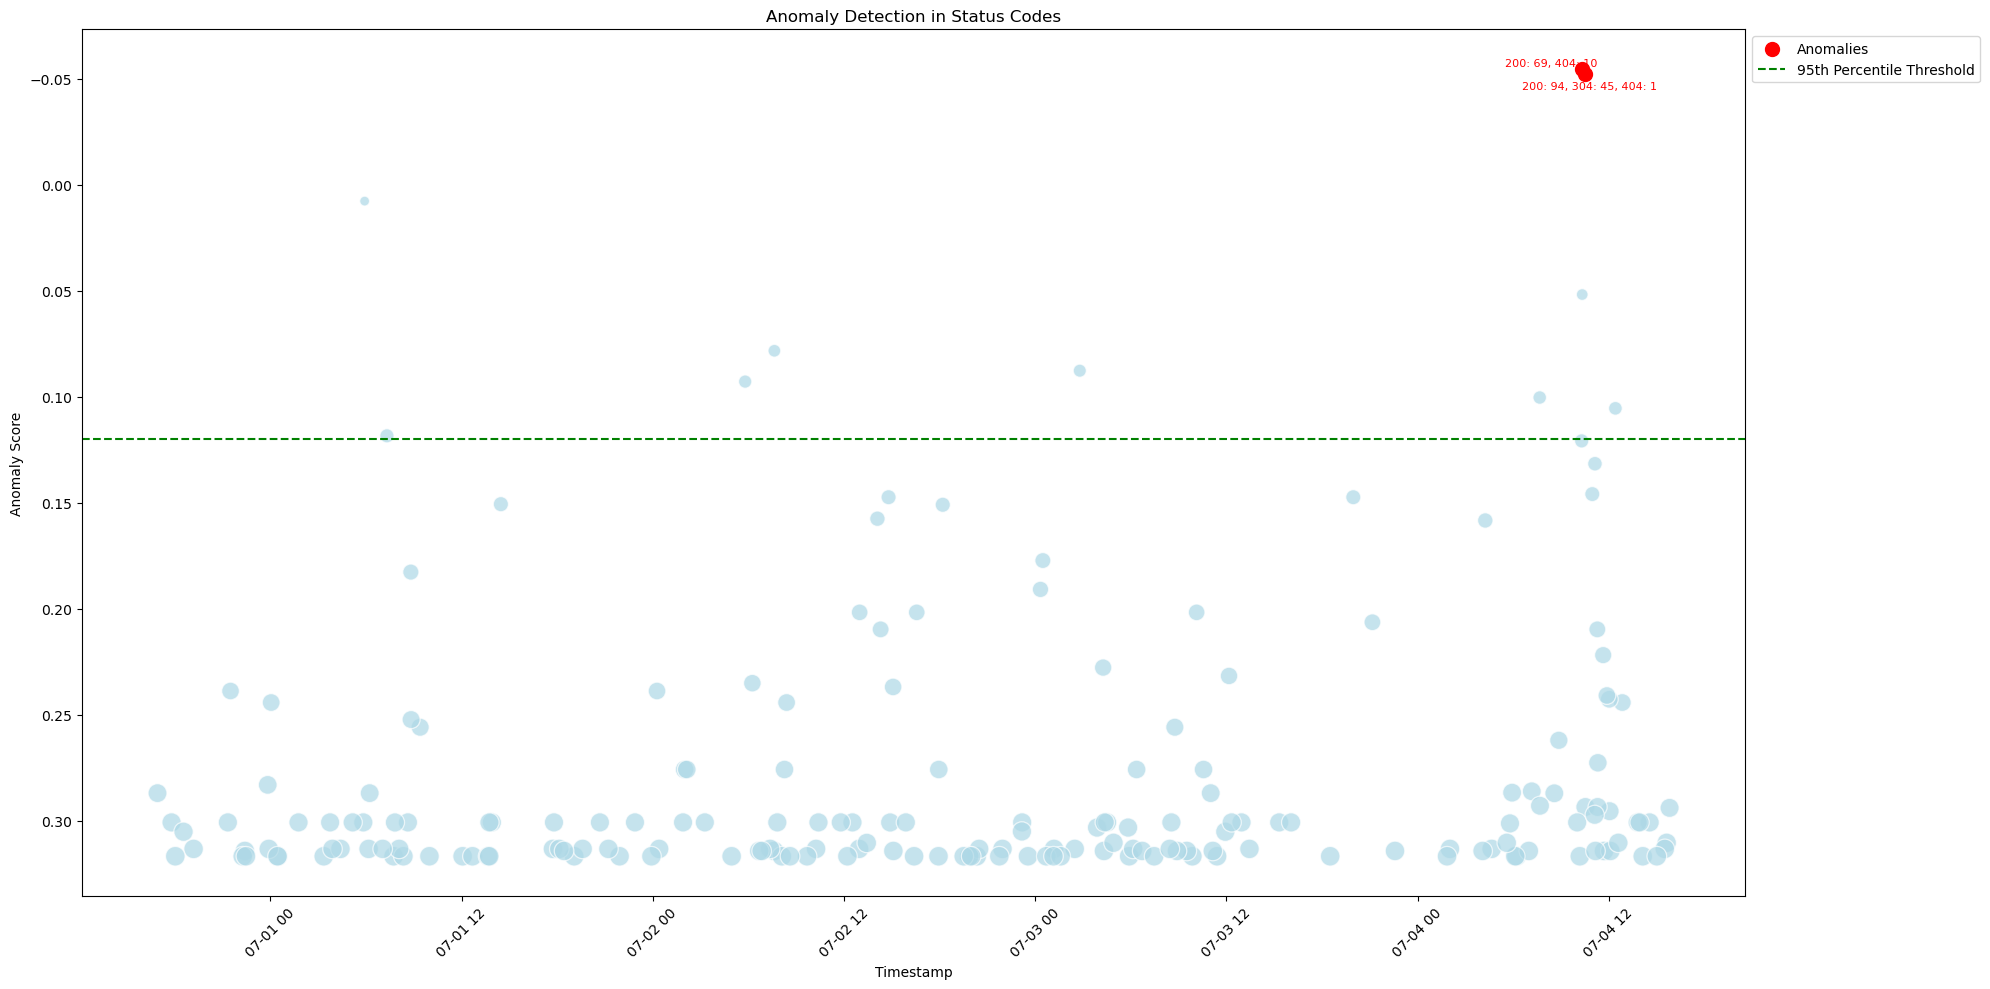

In [135]:
def plot_anomalies_status(features, timestamp_col='Timestamp', anomaly_col='anomaly_score'):
    # Check for required columns
    if timestamp_col not in features.columns or anomaly_col not in features.columns:
        raise KeyError("One or more required columns are missing from the DataFrame.")
    
    plt.figure(figsize=(20, 10))  

   
    scatter = sns.scatterplot(
        x=features[timestamp_col],
        y=features[anomaly_col],
        hue=features['anomaly'],
        size=features[anomaly_col],
        sizes=(20, 200),
        palette={-1: 'red', 1: 'lightblue'},
        alpha=0.7,
        legend=False  
    )
    
    anomaly_points = features[features['anomaly'] == -1]
    plt.scatter(anomaly_points[timestamp_col], anomaly_points[anomaly_col], color='red', s=100, label='Anomalies')
    

    texts = []
    for i, row in anomaly_points.iterrows():
        # Get status codes with non-zero values
        contributing_statuses = {col: row[col] for col in features.columns if isinstance(col, int) and row[col] > 0}
        annotation_text = ', '.join([f"{status}: {count}" for status, count in contributing_statuses.items()])
        
        texts.append(plt.text(row[timestamp_col], row[anomaly_col], annotation_text,
                     fontsize=8, ha='center', color='red'))
    
    adjust_text(texts, arrowprops=dict(arrowstyle="->", color='red')) # Iteratively adjusts the positions of text annotations to minimze overlap 

    plt.gca().invert_yaxis()  # Invert the y-axis

    plt.axhline(y=np.percentile(features[anomaly_col], 5), color='green', linestyle='--', label='95th Percentile Threshold')
    
    plt.title('Anomaly Detection in Status Codes')
    plt.xlabel('Timestamp')
    plt.ylabel('Anomaly Score')

    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend to the upper left, outside the plot area
    plt.xticks(rotation=45)

    plt.subplots_adjust(left=0.1, right=0.85, top=0.9, bottom=0.2)
    
    plt.tight_layout()
    plt.show()
    
# Ensure Timestamp is reset and combined correctly
dev_status = dev_status.reset_index() # Since the dataframe was unstacked, status codes were given as column headers while timestamp was excluded and only used as an index
test_status = test_status.reset_index() # Resetting the index to include timestamp as a column

combined_status = pd.concat([dev_status, test_status])

plot_anomalies_status(combined_status)